In [1]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
from scipy import io as sio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
%matplotlib inline

from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


from tensorflow.keras import Model, Sequential, layers, optimizers, activations
from sklearn.feature_extraction.image import extract_patches_2d
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
def load_HSI(path):
    try:
        data = sio.loadmat(path)
    except NotImplementedError:
        data = hdf.File(path, 'r')

    Y = np.asarray(data['Y'], dtype=np.float32)
    GT = np.asarray(data['GT'], dtype=np.float32)
    if Y.shape[0] < Y.shape[1]:
        Y = Y.transpose()
    Y = Y / np.max(Y.flatten())
    n_bands = Y.shape[1]
    n_rows = data['lines'].item()
    n_cols = data['cols'].item()
    Y = np.reshape(Y, (n_cols, n_rows, n_bands))
    return Y, GT

In [5]:
def training_input_fn(hsi, patch_size, patch_number, batch_size):
    patches = extract_patches_2d(hsi, (patch_size, patch_size), max_patches=patch_number)
    return patches

In [6]:
class SumToOne(tf.keras.layers.Layer):
    def __init__(self, params, **kwargs):
        super(SumToOne, self).__init__(**kwargs)
        self.num_outputs = params['num_endmembers']
        self.params = params

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

    def call(self, x):
        x = tf.nn.softmax(self.params['scale'] * x)
        return x

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.params = params
        self.hidden_layer_one = tf.keras.layers.Conv2D(filters=self.params['e_filters'],
                                                       kernel_size=self.params['e_size'],
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=params['initializer'], use_bias=False)
        self.hidden_layer_two = tf.keras.layers.Conv2D(filters=self.params['num_endmembers'], kernel_size=1,
                                                       activation=self.params['activation'], strides=1, padding='same',
                                                       kernel_initializer=self.params['initializer'], use_bias=False)
        self.asc_layer = SumToOne(params=self.params, name='abundances')

    def call(self, input_patch):
        code = self.hidden_layer_one(input_patch)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.hidden_layer_two(code)
        code = tf.keras.layers.BatchNormalization()(code)
        code = tf.keras.layers.SpatialDropout2D(0.2)(code)
        code = self.asc_layer(code)
        return code

In [8]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.output_layer = tf.keras.layers.Conv2D(filters=params['d_filters'], kernel_size=params['d_size'],
                                                   activation='linear',
                                                   kernel_constraint=tf.keras.constraints.non_neg(),
                                                   name='endmembers', strides=1, padding='same',
                                                   kernel_regularizer=None,
                                                   kernel_initializer=params['initializer'], use_bias=False)

    def call(self, code):
        recon = self.output_layer(code)
        return recon

    def getEndmembers(self):
        return self.output_layer.get_weights()

In [9]:
class Autoencoder(tf.keras.Model):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.params = params

    def call(self, patch):
        abunds = self.encoder(patch)
        # tf.summary.histogram('abunds', abunds, step=1)
        #         abunds = tf.keras.layers.SpatialDropout2D(0.08)(abunds)
        output = self.decoder(abunds)
        return output

    def getEndmembers(self):
        endmembers = self.decoder.getEndmembers()[0]
        if endmembers.shape[1] > 1:
            endmembers = np.squeeze(endmembers).mean(axis=0).mean(axis=0)
        else:
            endmembers = np.squeeze(endmembers)
        return endmembers

    def getAbundances(self, hsi):
        return np.squeeze(self.encoder.predict(np.expand_dims(hsi, 0)))

    def train(self, patches, callback):
        self.plotWhileTraining = callback
        self.fit(patches, patches, epochs=self.params['epochs'], batch_size=self.params['batch_size'],
                 callbacks=[self.plotWhileTraining], verbose=0)

    def saveResults(self, fname):
        endmembers = self.getEndmembers()
        abundances = self.getAbundances(params['data'])
        sads = self.plotWhileTraining.sads
        sio.savemat(fname, {'M': endmembers, 'A': abundances, 'sads': sads})

In [10]:
def SAD(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    A = (y_true * y_pred)
    sad = tf.math.acos(A)
    return sad

def numpy_SAD(y_true, y_pred):
    return np.arccos(y_pred.dot(y_true) / (np.linalg.norm(y_true) * np.linalg.norm(y_pred)))


def loss(model, original):
    reconstruction_error = SAD(model(original), original)
    return reconstruction_error

In [11]:
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        gradients = tape.gradient(loss(model, original) + sum(model.losses), model.trainable_variables)
        gradient_variables = zip(gradients, model.trainable_variables)
        opt.apply_gradients(gradient_variables)


def order_endmembers(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    dict = {}
    sad_mat = np.ones((num_endmembers, num_endmembers))
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()
    for i in range(num_endmembers):
        for j in range(num_endmembers):
            sad_mat[i, j] = numpy_SAD(endmembers[i, :], endmembersGT[j, :])
    rows = 0
    while rows < num_endmembers:
        minimum = sad_mat.min()
        index_arr = np.where(sad_mat == minimum)
        if len(index_arr) < 2:
            break
        index = (index_arr[0][0], index_arr[1][0])
        if index[0] in dict.keys():
            sad_mat[index[0], index[1]] = 100
        elif index[1] in dict.values():
            sad_mat[index[0], index[1]] = 100
        else:
            dict[index[0]] = index[1]
            sad_mat[index[0], index[1]] = 100
            rows += 1
    ASAM = 0
    num = 0
    for i in range(num_endmembers):
        if np.var(endmembersGT[dict[i]]) > 0:
            ASAM = ASAM + numpy_SAD(endmembers[i, :], endmembersGT[dict[i]])
            num += 1

    return dict, ASAM / float(num)
def plotEndmembers(endmembers):
    endmembers = endmembers / endmembers.max()
    fig = plt.figure(1)
    for i in range(num_endmembers):
        ax = plt.subplot(2, 2, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        ax.get_xaxis().set_visible(False)
    plt.tight_layout()
    plt.show()


def plotEndmembersAndGT(endmembers, endmembersGT):
    num_endmembers = endmembers.shape[0]
    n = num_endmembers // 2  # how many digits we will display
    if num_endmembers % 2 != 0: n = n + 1
    dict, sad = order_endmembers(endmembers, endmembersGT)

    fig = plt.figure(num=1, figsize=(8, 8))
    plt.clf()
    title = "aSAM score for all endmembers: " + format(sad, '.3f') + " radians"
    st = plt.suptitle(title)
    for i in range(num_endmembers):
        endmembers[i, :] = endmembers[i, :] / endmembers[i, :].max()
        endmembersGT[i, :] = endmembersGT[i, :] / endmembersGT[i, :].max()

    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(endmembers[i, :], 'r', linewidth=1.0)
        plt.plot(endmembersGT[dict[i], :], 'k', linewidth=1.0)
        ax.set_title("SAD: " + str(i) + " :" + format(numpy_SAD(endmembers[i, :], endmembersGT[dict[i], :]), '.4f'))
        ax.get_xaxis().set_visible(False)

    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.88)
    plt.draw()
    plt.pause(0.001)


def plotAbundancesSimple(abundances):
    abundances = np.transpose(abundances, axes=[1, 0, 2])
    num_endmembers = abundances.shape[2]
    n = num_endmembers // 2
    if num_endmembers % 2 != 0: n = n + 1
    fig = plt.figure(2, figsize=[8, 8])
    for i in range(num_endmembers):
        ax = plt.subplot(2, n, i + 1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(position='bottom', size='5%', pad=0.05)
        im = ax.imshow(abundances[:, :, i], cmap='viridis')
        plt.colorbar(im, cax=cax, orientation='horizontal')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        im.set_clim([0, 1])
    plt.tight_layout()
    plt.draw()
    plt.pause(0.001)


class PlotWhileTraining(tf.keras.callbacks.Callback):
    def __init__(self, plot_every_n, hsi, gt):
        super(PlotWhileTraining, self).__init__()
        self.plot_every_n = plot_every_n
        num_endmembers = gt.shape[0]
        self.num_endmembers = num_endmembers
        self.input = hsi
        self.endmembersGT = gt
        self.sads = None

    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_loss = []
        self.sads = []

    def on_batch_end(self, batch, logs={}):
        return

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('SAD'))
        self.num_epochs = epoch
        print('*',end='')
        if self.plot_every_n == 0 or epoch % self.plot_every_n != 0:
            return
        plotEndmembersAndGT(self.endmembersGT, endmembers)
        abundances = self.model.getAbundances(self.input)
        plotAbundancesSimple(abundances)

In [14]:
n_bands = 162
num_endmembers = 4
patch_size = 40
num_patches = 250
batch_size = 15
learning_rate = 0.003
epochs = 320

scale = 3 #scaling for softmax
l2 = 0
l1 = 0e-8
tv = 0e-8

activation = tf.keras.layers.LeakyReLU(0.02)
initializer = tf.keras.initializers.RandomNormal(0.0, 0.3)
regularizer = tf.keras.regularizers.l2(l2)

opt = tf.optimizers.legacy.RMSprop(learning_rate=learning_rate, decay=0.0)

# Load dataset

#Dictonary of aliases for datasets. The first string is the key and second is value (name of matfile without .mat suffix)
#Useful when looping over datasets
datasetnames = {
    "Urban": "Urban4",
}
dataset = "Urban"
data,GT = load_HSI(
    "Urban4"
)

#e_filters is the number of featuremaps in the first hidden layer
#d_size is the decoder's filter size
#e_size is the size of the hidden layer's filter

params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
          'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
          'initializer': initializer, 'l1': l1, 'tv': tv, 'patch_size': patch_size,
          'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}

Run number: 1


Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


********************************************************************************************************************************************************************************************************************************************************************************************************************************

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


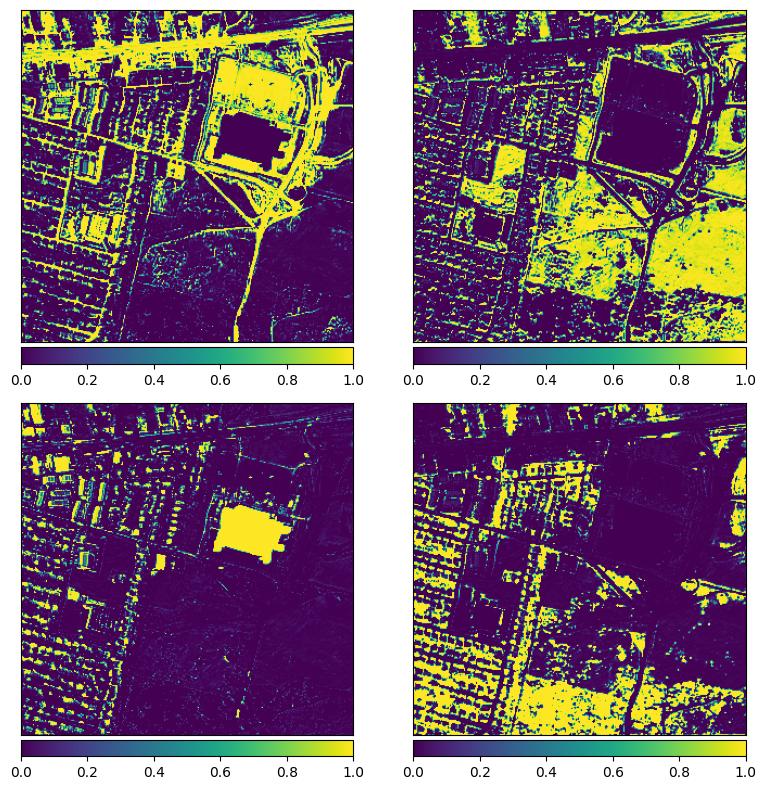

NameError: name 'hsi' is not defined

In [ ]:
num_runs = 25
results_folder = './Results'
method_name = 'CNNAEU'

plot_every_n = 0 #Plot endmembers and abundance maps every x epochs. Set to 0 when running experiments.
for dataset in ['Urban']:
    save_folder = results_folder+'/'+method_name+'/'+dataset
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    dataset_name = 'synthetic'

    data,GT = load_HSI(
        "Urban4.mat"
    )
    for i in range(num_runs):
        print('Run number: '+str(i+1))
        save_name = dataset_name+'_run'+str(i)+'.mat'
        save_path = save_folder+'/'+save_name
        patches = training_input_fn(data, patch_size, num_patches, batch_size)
        params = {'e_filters': 48, 'e_size': 3, 'd_filters': n_bands, 'd_size': 13, 'activation': activation,
              'num_endmembers': num_endmembers, 'scale': scale, 'regularizer': regularizer,
              'initializer': initializer, 'patch_size': patch_size,
              'batch_size': batch_size, 'num_patches': num_patches, 'data': data, 'epochs': epochs}
        autoencoder = Autoencoder(params)

        autoencoder.compile(opt, loss=SAD)
        autoencoder.train(callback=PlotWhileTraining(plot_every_n, data, GT), patches=patches)
        endmembers = autoencoder.getEndmembers()
        abundances = autoencoder.getAbundances(data)
        plotAbundancesSimple(abundances)
        plotEndmembersAndGT(endmembers,hsi.gt)
        autoencoder.saveResults(save_path+'_run' + str(i+1) + '.mat')
        del autoencoder